# Composite Gaussian Process Model for SOGP

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import random
from scipy.stats import norm
import math
from math import pi, cos, sin, gamma
from matplotlib import pyplot as plt
from numpy import array

## Testing function

### 1. 

### $$f(x)=An+\sum_{i=1}^{n} x_i^2 - A cos(2 \pi x_i)$$
where n represent the dimension of x and A=10

In [2]:
def Rastrigin_f(x):
    A = 10
    row, col = x.shape
    part_1 = A * col
    part_2 = x ** 2
    part_3 = A * np.apply_along_axis(cos, 1, 2 * pi * x).reshape(-1, 1)
    result = part_1 + np.sum(part_2 - part_3, axis=1)
    return result

### 2. 

### $$y(x) = sin[30(x-0.9)^4] cos[2(x-0.9)]+(x-0.9)/2$$

In [3]:
def Sphere_f(x):
    x = 0.1*x
    part_1 =  np.apply_along_axis(sin,1,30*(x-0.9)**4).reshape(-1, 1)
    part_2 = np.apply_along_axis(cos,1, 2 *(x-0.9)).reshape(-1, 1)
    part_3 = (x-0.9)/2
    result = part_1*part_2+part_3
    return result

## Data generate

In [4]:
sample_size = 10

X=np.random.choice(10,size=(sample_size,1),replace=False)+np.random.rand(sample_size, 1)
X = X
X.sort(axis=0)

y1 = Rastrigin_f(X)
y1 = y1.reshape(-1, 1)


y2 = Sphere_f(X)
y2 = y2.reshape(-1, 1)


## transform array into tensor
X = torch.Tensor(X)

y1 = torch.Tensor(y1)

y2 = torch.Tensor(y2)

## Model 1 ( Improving the mean model )

### $$Y(x) = Z_{global} \ (x)+Z_{local}(x)$$

### $$Z_{global} \ (x)   \sim  GP(\mu,\tau^2 g(.))$$

### $$Z_{local} \  (x)    \sim    GP(0,\sigma^2 l(.))$$

In [5]:
def Sphere_f_EI(x):
    A = 10
    col = x.shape[0]
    part_1 = A * col
    part_2 = x ** 2
    part_3 = A * np.apply_along_axis(cos, 1, 2 * pi * x).reshape(-1, 1)
    result = part_1 + np.sum(part_2 - part_3, axis=1)
    return result

In [6]:
# 僅改善常數平均數的模型 for train data(X,y)
class CGP(nn.Module):
    def __init__(self,x_dimension,tau):
        super(CGP, self).__init__()
        self.x_dimension = x_dimension # dimension of input vector
        self.tau = tau #variance 0f global trend
        
        self.init_parameters()

    def init_parameters(self):
        # parameters of global trend's correlation function 
        self.theta = Parameter(torch.tensor([1.0] * self.x_dimension).view(1, -1))
        # parameters of local trend's correlation function 
        self.alpha = Parameter(torch.tensor([1.0] * self.x_dimension).view(1, -1))
        # ratio of variances
        self.lamb = Parameter(torch.tensor([1.0] * 1).view(1, -1))
        
 #   def del_tensor_ele(arr,index):
#      arr1 = arr[0:index]
#        arr2 = arr[index+1:]
#       return torch.cat((arr1,arr2),dim=0)
        
        
    def alpha_lowerbound(self, x1, x2):
        n1, n2 = x1.shape[0], x2.shape[0]
        P1, P2 = x1.repeat(1, n2).view(-1, self.x_dimension), x2.repeat(n1, 1)
        
        temp =  ((P1 - P2) ** 2)
        
        b = temp.view(-1)
        
        b1 = torch.cat((b[1:11],b[12:22]),0)
        b2 = torch.cat((b[23:33],b[34:44]),0)
        b3 = torch.cat((b[45:55],b[56:66]),0)
        b4 = torch.cat((b[67:77],b[78:88]),0)
        b12 = torch.cat((b1,b2),0)
        b34 = torch.cat((b3,b4),0)
        b1234 = torch.cat((b12,b34),0)
        total = torch.cat((b1234,b[89:99]),0)


        avg_dist =  ((2/n1)*1/(n1-1))*(1/total).sum().item()
        alpha_lower_bound = torch.log(torch.tensor([100.])).item()*avg_dist
        alpha_lower_bound = math.log(alpha_lower_bound)

        return alpha_lower_bound
        
    def adjust_corr_parameters(self,x1,x2):
        with torch.no_grad():
            alpha_lower_bound = self.alpha_lowerbound(x1, x2)
            self.theta.clamp_(min=0.001,max=alpha_lower_bound)
            self.alpha.clamp_(min=alpha_lower_bound+0.001,max=alpha_lower_bound+3)


    def adjust_lambda_parameter(self):
        with torch.no_grad():
            self.lamb.clamp_(min=0.001,max=0.999)

##########################################                 
    #def get_obj(self, fun):
    #    self.objF = fun
##########################################      

    def train_datas(self, trainX, trainY=None):
        self.trainX = trainX
        if trainY is not None:
            self.trainY = trainY
        else:
            self.trainY = self.objF(self.dataTransfer(trainX))

    # use Gaussian correlation function to calculate covariance matrix between x1 matrix and x2 matrix
    ## global trend
    def covariance_g(self, x1, x2):
        n1, n2 = x1.shape[0], x2.shape[0]
        P1, P2 = x1.repeat(1, n2).view(-1, self.x_dimension), x2.repeat(n1, 1)

        temp = (-1) * (self.theta * (P1 - P2) ** 2).sum(dim=1)
        temp = self.tau * torch.exp(temp)
        outputs = temp.view(n1, n2)
        
        return outputs

    ## local trend
    def covariance_l(self, x1, x2):
        n1, n2 = x1.shape[0], x2.shape[0]
        P1, P2 = x1.repeat(1, n2).view(-1, self.x_dimension), x2.repeat(n1, 1)

        temp = (-1) * (self.alpha * (P1 - P2) ** 2).sum(dim=1)
        temp = (self.lamb*self.tau) * torch.exp(temp)
        outputs = temp.view(n1, n2)
        
        return outputs
 

    def MLE(self):
        n = self.trainX.shape[0]
        G =  self.covariance_g(self.trainX, self.trainX)
        L = self.covariance_l(self.trainX, self.trainX)
        ones = torch.ones(n, 1)
        
        term = G+self.lamb*L

        termInverse = torch.inverse(term).float()
        termone = torch.inverse(ones.T.mm(termInverse).mm(ones)).float()
        termtwo = ones.T.mm(termInverse).float()
        
        mu = termone.mm(termtwo).mm(self.trainY)
        tau = (1/n)* (self.trainY - ones * mu).T.mm(termInverse).mm(self.trainY - ones * mu)
        self.tau = tau.detach().clone()
        
        termDeterminant = torch.det(term)

        p_1 = (termDeterminant > 0).type(torch.float)
        termDeterminant = termDeterminant*p_1

        neglog_likelihood = n * torch.log(tau+1) + torch.log(termDeterminant+1) + ((self.trainY - ones * mu).T.mm(termInverse).mm(self.trainY - ones * mu))/tau
        
        
        return neglog_likelihood, mu, tau
    
    def pred(self, W):
        with torch.no_grad():
            n = self.trainX.shape[0]
            G = self.covariance_g(self.trainX, self.trainX)
            g = self.covariance_g(W, self.trainX)
            
            L = self.covariance_l(self.trainX, self.trainX)
            l = self.covariance_l(W, self.trainX)
            
            ones = torch.ones(n, 1)
        
            term = G+self.lamb*L
            term = term+1e-6* torch.eye(term.shape[0])
            termInverse = torch.inverse(term).float()   
            
            termone = torch.inverse(ones.T.mm(termInverse).mm(ones)).float()
            termtwo = ones.T.mm(termInverse).float()
            termthree = g+self.lamb*l
            
            mu = termone.mm(termtwo).mm(self.trainY)
            termfour = self.trainY-mu*ones
        
            pred = mu+termthree.mm(termInverse).mm(termfour)
            
            return pred

        
    def pred_MSE(self, W):
        with torch.no_grad():
            n = self.trainX.shape[0]
            G = self.covariance_g(self.trainX, self.trainX)
            g = self.covariance_g(W, self.trainX)
            
            L = self.covariance_l(self.trainX, self.trainX)
            l = self.covariance_l(W, self.trainX)
            
            ones = torch.ones(n, 1)
            
            section = self.covariance_g(W,W)+self.lamb*self.covariance_l(W,W)
            section = torch.diag(section).view(-1,1)

            term = G+self.lamb*L
            term = term+1e-6* torch.eye(term.shape[0])
            termInverse = torch.inverse(term).float()            

            termone = torch.inverse(ones.T.mm(termInverse).mm(ones)).float()
            termtwo = ones.T.mm(termInverse).float()
            termthree = g+self.lamb*l
            
            partone = termthree.mm(termInverse).mm(termthree.T).float()
            partone = torch.diag(partone).view(-1,1)
            parttwo = ones.T.mm(termInverse).mm(termthree.T).float().T
            partthree = (1-parttwo)**2
            partfour = partthree/parttwo
            varPool = self.tau + self.lamb*self.tau
            
            predMSE = varPool*(section-partone+partfour)
            
            p = (predMSE > 0).type(torch.float)
            predMSE = predMSE * p # 如果有MSE的值算出來為0，讓它變成0
        return predMSE
        
    def EI(self, W):
        with torch.no_grad():
            predMSE = self.pred_MSE(W)
            yMin = torch.min(self.trainY)
            yPred = self.pred(W)
            isNotZero = (predMSE > 0.00001).type(torch.float)

            predMSE = predMSE + (-1) * (isNotZero - 1)

            c = yMin - yPred
            value = c / torch.sqrt(predMSE)
            nPdf = norm.pdf(value, loc=0, scale=1)
            nPdf = torch.tensor(nPdf, dtype=torch.float)
            nCdf = norm.cdf(value, loc=0, scale=1)
            nCdf = torch.tensor(nCdf, dtype=torch.float)
            outputs = (c * nCdf + torch.sqrt(predMSE) * nPdf) * isNotZero
        return outputs

    
    # 生成所有可能的點，準備丟到 EI 去選點
    def every_points(self):      # 以 0.1 為區間
#         grids = [np.arange(0, 10.1, 0.01)]*1 #因為生成的資料維度為1，所以乘以1
#         grids = np.meshgrid(*grids)
#         grids = list(map(torch.tensor, grids))
#         for i, j in enumerate(grids):
#             grids[i] = torch.unsqueeze(j, dim=0) #要將兩個平面相加，必須先給予一個新的維度
#         grids = torch.cat(grids, dim=0).view(1, -1).T
        test_x = np.linspace(0, 10, num=1000).reshape(-1, 1)

        return torch.tensor(test_x).float()       

    
    # 使用EI選點並加入 model 資料當中
    def EI_get_points(self):
        W = self.every_points()
        EICurve = self.EI(W)
        EIIndex = EICurve.argmax().item()
        maxPoint = W[[EIIndex], :]
        y = Rastrigin_f(maxPoint.numpy())
        self.trainX = torch.cat([self.trainX, maxPoint], dim=0)
        self.trainY = torch.cat([self.trainY, torch.tensor(y).float().view(-1,1)], dim=0)
        return maxPoint

In [7]:
# 僅改善常數平均數的模型 for train data(X,y)
class CGP1(nn.Module):
    def __init__(self,x_dimension,tau):
        super(CGP1, self).__init__()
        self.x_dimension = x_dimension # dimension of input vector
        self.tau = tau #variance 0f global trend
        
        self.init_parameters()

    def init_parameters(self):
        # parameters of global trend's correlation function 
        self.theta = Parameter(torch.tensor([1.0] * self.x_dimension).view(1, -1))
        # parameters of local trend's correlation function 
        self.alpha = Parameter(torch.tensor([1.0] * self.x_dimension).view(1, -1))
        # ratio of variances
        self.lamb = Parameter(torch.tensor([1.0] * 1).view(1, -1))
        
 #   def del_tensor_ele(arr,index):
#      arr1 = arr[0:index]
#        arr2 = arr[index+1:]
#       return torch.cat((arr1,arr2),dim=0)
        
        
    def alpha_lowerbound(self, x1, x2):
        n1, n2 = x1.shape[0], x2.shape[0]
        P1, P2 = x1.repeat(1, n2).view(-1, self.x_dimension), x2.repeat(n1, 1)
        
        temp =  ((P1 - P2) ** 2)
        
        b = temp.view(-1)
        
        b1 = torch.cat((b[1:11],b[12:22]),0)
        b2 = torch.cat((b[23:33],b[34:44]),0)
        b3 = torch.cat((b[45:55],b[56:66]),0)
        b4 = torch.cat((b[67:77],b[78:88]),0)
        b12 = torch.cat((b1,b2),0)
        b34 = torch.cat((b3,b4),0)
        b1234 = torch.cat((b12,b34),0)
        total = torch.cat((b1234,b[89:99]),0)


        avg_dist =  ((2/n1)*1/(n1-1))*(1/total).sum().item()
        alpha_lower_bound = torch.log(torch.tensor([100.])).item()*avg_dist
        alpha_lower_bound = math.log(alpha_lower_bound)

        return alpha_lower_bound
        
    def adjust_corr_parameters(self,x1,x2):
        with torch.no_grad():
            alpha_lower_bound = self.alpha_lowerbound(x1, x2)
            self.theta.clamp_(min=0.001,max=alpha_lower_bound)
            self.alpha.clamp_(min=alpha_lower_bound+0.001,max=alpha_lower_bound+3)


    def adjust_lambda_parameter(self):
        with torch.no_grad():
            self.lamb.clamp_(min=0.001,max=0.999)

##########################################                 
    #def get_obj(self, fun):
    #    self.objF = fun
##########################################      

    def train_datas(self, trainX, trainY=None):
        self.trainX = trainX
        if trainY is not None:
            self.trainY = trainY
        else:
            self.trainY = self.objF(self.dataTransfer(trainX))

    # use Gaussian correlation function to calculate covariance matrix between x1 matrix and x2 matrix
    ## global trend
    def covariance_g(self, x1, x2):
        n1, n2 = x1.shape[0], x2.shape[0]
        P1, P2 = x1.repeat(1, n2).view(-1, self.x_dimension), x2.repeat(n1, 1)

        temp = (-1) * (self.theta * (P1 - P2) ** 2).sum(dim=1)
        temp = self.tau * torch.exp(temp)
        outputs = temp.view(n1, n2)
        
        return outputs

    ## local trend
    def covariance_l(self, x1, x2):
        n1, n2 = x1.shape[0], x2.shape[0]
        P1, P2 = x1.repeat(1, n2).view(-1, self.x_dimension), x2.repeat(n1, 1)

        temp = (-1) * (self.alpha * (P1 - P2) ** 2).sum(dim=1)
        temp = (self.lamb*self.tau) * torch.exp(temp)
        outputs = temp.view(n1, n2)
        
        return outputs
 

    def MLE(self):
        n = self.trainX.shape[0]
        G =  self.covariance_g(self.trainX, self.trainX)
        L = self.covariance_l(self.trainX, self.trainX)
        ones = torch.ones(n, 1)
        
        term = G+self.lamb*L

        termInverse = torch.inverse(term).float()
        termone = torch.inverse(ones.T.mm(termInverse).mm(ones)).float()
        termtwo = ones.T.mm(termInverse).float()
        
        mu = termone.mm(termtwo).mm(self.trainY)
        tau = (1/n)* (self.trainY - ones * mu).T.mm(termInverse).mm(self.trainY - ones * mu)
        self.tau = tau.detach().clone()
        
        termDeterminant = torch.det(term)

        p_1 = (termDeterminant > 0).type(torch.float)
        termDeterminant = termDeterminant*p_1

        neglog_likelihood = n * torch.log(tau+1) + torch.log(termDeterminant+1) + ((self.trainY - ones * mu).T.mm(termInverse).mm(self.trainY - ones * mu))/tau
        
        
        return neglog_likelihood, mu, tau
    
    def pred(self, W):
        with torch.no_grad():
            n = self.trainX.shape[0]
            G = self.covariance_g(self.trainX, self.trainX)
            g = self.covariance_g(W, self.trainX)
            
            L = self.covariance_l(self.trainX, self.trainX)
            l = self.covariance_l(W, self.trainX)
            
            ones = torch.ones(n, 1)
        
            term = G+self.lamb*L
            term = term+1e-6* torch.eye(term.shape[0])
            termInverse = torch.inverse(term).float()   
            
            termone = torch.inverse(ones.T.mm(termInverse).mm(ones)).float()
            termtwo = ones.T.mm(termInverse).float()
            termthree = g+self.lamb*l
            
            mu = termone.mm(termtwo).mm(self.trainY)
            termfour = self.trainY-mu*ones
        
            pred = mu+termthree.mm(termInverse).mm(termfour)
            
            return pred

        
    def pred_MSE(self, W):
        with torch.no_grad():
            n = self.trainX.shape[0]
            G = self.covariance_g(self.trainX, self.trainX)
            g = self.covariance_g(W, self.trainX)
            
            L = self.covariance_l(self.trainX, self.trainX)
            l = self.covariance_l(W, self.trainX)
            
            ones = torch.ones(n, 1)
            
            section = self.covariance_g(W,W)+self.lamb*self.covariance_l(W,W)
            section = torch.diag(section).view(-1,1)

            term = G+self.lamb*L
            term = term+1e-6* torch.eye(term.shape[0])
            termInverse = torch.inverse(term).float()            

            termone = torch.inverse(ones.T.mm(termInverse).mm(ones)).float()
            termtwo = ones.T.mm(termInverse).float()
            termthree = g+self.lamb*l
            
            partone = termthree.mm(termInverse).mm(termthree.T).float()
            partone = torch.diag(partone).view(-1,1)
            parttwo = ones.T.mm(termInverse).mm(termthree.T).float().T
            partthree = (1-parttwo)**2
            partfour = partthree/parttwo
            varPool = self.tau + self.lamb*self.tau
            
            predMSE = varPool*(section-partone+partfour)
            
            p = (predMSE > 0).type(torch.float)
            predMSE = predMSE * p # 如果有MSE的值算出來為0，讓它變成0
        return predMSE
        
    def EI(self, W):
        with torch.no_grad():
            predMSE = self.pred_MSE(W)
            yMin = torch.min(self.trainY)
            yPred = self.pred(W)
            isNotZero = (predMSE > 0.00001).type(torch.float)

            predMSE = predMSE + (-1) * (isNotZero - 1)

            c = yMin - yPred
            value = c / torch.sqrt(predMSE)
            nPdf = norm.pdf(value, loc=0, scale=1)
            nPdf = torch.tensor(nPdf, dtype=torch.float)
            nCdf = norm.cdf(value, loc=0, scale=1)
            nCdf = torch.tensor(nCdf, dtype=torch.float)
            outputs = (c * nCdf + torch.sqrt(predMSE) * nPdf) * isNotZero
        return outputs

    
    # 生成所有可能的點，準備丟到 EI 去選點
    def every_points(self):      # 以 0.1 為區間
#         grids = [np.arange(0, 10.1, 0.01)]*1 #因為生成的資料維度為1，所以乘以1
#         grids = np.meshgrid(*grids)
#         grids = list(map(torch.tensor, grids))
#         for i, j in enumerate(grids):
#             grids[i] = torch.unsqueeze(j, dim=0) #要將兩個平面相加，必須先給予一個新的維度
#         grids = torch.cat(grids, dim=0).view(1, -1).T
        test_x = np.linspace(0, 10, num=1000).reshape(-1, 1)

        return torch.tensor(test_x).float()       

    
    # 使用EI選點並加入 model 資料當中
    def EI_get_points(self):
        W = self.every_points()
        EICurve = self.EI(W)
        EIIndex = EICurve.argmax().item()
        maxPoint = W[[EIIndex], :]
        y = Sphere_f_EI(maxPoint.numpy())
        self.trainX = torch.cat([self.trainX, maxPoint], dim=0)
        self.trainY = torch.cat([self.trainY, torch.tensor(y).float().view(-1,1)], dim=0)
        return maxPoint

## Model 2 ( Improving both the mean and variance models )

### $$Y(x) = Z_{global} \ (x)+\sigma(x)  Z_{local}(x)$$

### $$Z_{global} \ (x)   \sim  GP(\mu,\tau^2 g(.))$$

### $$Z_{local} \  (x)    \sim    GP(0,l(.))$$

In [8]:
class CGPB(nn.Module):
    def __init__(self,x_dimension,tau):
        super(CGPB, self).__init__()
        self.x_dimension = x_dimension # dimension of input vector
        self.tau = tau #variance 0f global trend
        self.init_parameters()

    def init_parameters(self):
        
        # parameters of global trend's correlation function 
        self.theta = Parameter(torch.tensor([1.0] * self.x_dimension).view(1, -1))
        # parameters of local trend's correlation function 
        self.alpha = Parameter(torch.tensor([1.0] * self.x_dimension).view(1, -1))
        # ratio of variances
        self.lamb = Parameter(torch.tensor([1.0] * 1).view(1, -1))
        # extra bandwidth parameter
        self.b = Parameter(torch.tensor([1.0] * 1).view(1, -1))
        
        
    def alpha_lowerbound(self, x1, x2):
        n1, n2 = x1.shape[0], x2.shape[0]
        P1, P2 = x1.repeat(1, n2).view(-1, self.x_dimension), x2.repeat(n1, 1)
        
        temp =  ((P1 - P2) ** 2)
        
        b = temp.view(-1)
        b1 = torch.cat((b[1:11],b[12:22]),0)
        b2 = torch.cat((b[23:33],b[34:44]),0)
        b3 = torch.cat((b[45:55],b[56:66]),0)
        b4 = torch.cat((b[67:77],b[78:88]),0)
        b12 = torch.cat((b1,b2),0)
        b34 = torch.cat((b3,b4),0)
        b1234 = torch.cat((b12,b34),0)
        total = torch.cat((b1234,b[89:99]),0)

        avg_dist =  ((2/n1)*1/(n1-1))*(1/total).sum().item()

        alpha_lower_bound = torch.log(torch.tensor([100.])).item()*avg_dist
        alpha_lower_bound = math.log(alpha_lower_bound)

        return alpha_lower_bound
        
    def adjust_corr_parameters(self,x1,x2):
        with torch.no_grad():
            alpha_lower_bound = self.alpha_lowerbound(x1, x2)
            self.theta.clamp_(min=0.3,max=alpha_lower_bound)
            self.alpha.clamp_(min=alpha_lower_bound+0.001,max=alpha_lower_bound+5)

    def adjust_lambda_parameter(self):
        with torch.no_grad():
            self.lamb.clamp_(min=0.001,max=0.999)

    def adjust_b_parameter(self):
        with torch.no_grad():
            self.b.clamp_(min=0.001,max=0.999)

##########################################                 
    #def get_obj(self, fun):
    #    self.objF = fun
##########################################      

    def train_datas(self, trainX, trainY=None):
        self.trainX = trainX
        if trainY is not None:
            self.trainY = trainY
            n = self.trainX.shape[0]
            self.squ_residual = torch.ones(n, 1)
        else:
            self.trainY = self.objF(self.dataTransfer(trainX))

    # use Gaussian correlation function to calculate covariance matrix between x1 matrix and x2 matrix
    ## global trend
    def covariance_g(self, x1, x2):
        n1, n2 = x1.shape[0], x2.shape[0]
        P1, P2 = x1.repeat(1, n2).view(-1, self.x_dimension), x2.repeat(n1, 1)

        temp = (-1) * (self.theta * (P1 - P2) ** 2).sum(dim=1)
        temp = self.tau * torch.exp(temp)
        outputs = temp.view(n1, n2)
        
        return outputs

    ## local trend
    def covariance_l(self, x1, x2):
        n1, n2 = x1.shape[0], x2.shape[0]
        P1, P2 = x1.repeat(1, n2).view(-1, self.x_dimension), x2.repeat(n1, 1)

        temp = (-1) * (self.alpha * (P1 - P2) ** 2).sum(dim=1)
        temp = (self.lamb*self.tau) * torch.exp(temp)
        outputs = temp.view(n1, n2)
        
        return outputs

    # improve correlation function of global trend
    def correlation_g_b(self, x1, x2, s=False):
        n1, n2 = x1.shape[0], x2.shape[0]
        P1, P2 = x1.repeat(1, n2).view(-1, self.x_dimension), x2.repeat(n1, 1)

        temp = (-1) *self.b* (self.theta * (P1 - P2) ** 2).sum(dim=1)
        if s:
            print(self.b, self.theta, (P1 - P2) ** 2, sep='\n')
        temp = torch.exp(temp)
        outputs = temp.view(n1, n2)
        
        return outputs

##########################################
    # define variance function
    def variance_f(self,W):
        n = self.trainX.shape[0]
        ones = torch.ones(n, 1)
        gb = self.correlation_g_b(W, self.trainX)
        v = gb.mm(self.squ_residual)/gb.mm(ones)
        #print(gb)
        
        return v
 ##########################################  

    def MLE(self):
        n = self.trainX.shape[0]
        G =  self.covariance_g(self.trainX, self.trainX)
        L = self.covariance_l(self.trainX, self.trainX)
        ones = torch.ones(n, 1)
        
        diag_element = self.variance_f(self.trainX).view(-1)
        diag_matrix = torch.diag(diag_element)
        
      
        term =  G+self.lamb*(diag_matrix**(1/2)).mm(L).mm(diag_matrix**(1/2))
        termInverse = torch.inverse(term+1e-8 * torch.eye(term.shape[0])).float()

        termone = torch.inverse(ones.T.mm(termInverse).mm(ones)).float()
        termtwo = ones.T.mm(termInverse).float()
        
        mu = termone.mm(termtwo).mm(self.trainY)
        tau = (1/n)* (self.trainY - ones * mu).T.mm(termInverse).mm(self.trainY - ones * mu)
        self.tau = tau.detach().clone()
        
        termDeterminant = torch.det(term)
        p_1 = (termDeterminant > 0).type(torch.float)
        termDeterminant = termDeterminant*p_1

        neglog_likelihood = n * torch.log(tau+1)+ torch.log(termDeterminant+1)+ ((self.trainY - ones * mu).T.mm(termInverse).mm(self.trainY - ones * mu))/(tau+1)
    
        return neglog_likelihood, mu, tau
    
    def pred(self, W,stop=True):
        with torch.no_grad():
            n = self.trainX.shape[0]
            G = self.covariance_g(self.trainX, self.trainX)
            g = self.covariance_g(W, self.trainX)
            
            L = self.covariance_l(self.trainX, self.trainX)
            l = self.covariance_l(W, self.trainX)
            
            ones = torch.ones(n, 1)
            
            diag_element = self.variance_f(self.trainX).view(-1)
            diag_matrix = torch.diag(diag_element)
        
            term =  G+self.lamb*(diag_matrix**(1/2)).mm(L).mm(diag_matrix**(1/2))
            termInverse = torch.inverse(term+1e-8 * torch.eye(term.shape[0])).float()
            termone = torch.inverse(ones.T.mm(termInverse).mm(ones)).float()
            termtwo = ones.T.mm(termInverse).float()
            #termthree = g+(self.lamb*(self.variance_f(self.trainX)**(1/2)).T.mm(diag_matrix**(1/2)).mm(l.T)).T
            termthree = g+(self.lamb*(self.variance_f(self.trainX)**(1/2))*(diag_matrix**(1/2)).mm(l.T)).T
            
            mu = termone.mm(termtwo).mm(self.trainY)
            
            termfour = self.trainY-mu*ones
        
            pred = mu+termthree.mm(termInverse).mm(termfour)
            pred_g = mu+g.mm(termInverse).mm(termfour)
           
            if stop:
                s = self.trainY - self.pred(self.trainX,stop=False)[1]
                squ_s = s**2
                self.squ_residual = squ_s 
            
            return pred,pred_g
        
        
    def pred_MSE(self, W):
        with torch.no_grad():
            n = self.trainX.shape[0]
            G = self.covariance_g(self.trainX, self.trainX)
            g = self.covariance_g(W, self.trainX)
            
            L = self.covariance_l(self.trainX, self.trainX)
            l = self.covariance_l(W, self.trainX)

            diag_element = self.variance_f(self.trainX).view(-1)
            diag_matrix = torch.diag(diag_element)
            
            ones = torch.ones(n, 1)
            
            section = self.covariance_g(W,W)+self.lamb*self.covariance_l(W,W)
            section = torch.diag(section).view(-1,1)
        
            term =  G+self.lamb*(diag_matrix**(1/2)).mm(L).mm(diag_matrix**(1/2))
            termInverse = torch.inverse(term+1e-8 * torch.eye(term.shape[0])).float()
            termone = torch.inverse(ones.T.mm(termInverse).mm(ones)).float()
            termtwo = ones.T.mm(termInverse).float()
            termthree = g+(self.lamb*(self.variance_f(self.trainX)**(1/2)).T.mm(diag_matrix**(1/2)).mm(l.T)).T
            
            partone = termthree.mm(termInverse).mm(termthree.T).float()
            partone = torch.diag(partone).view(-1,1)
            parttwo = ones.T.mm(termInverse).mm(termthree.T).float().T
            partthree = (1-parttwo)**2
            partfour = partthree/parttwo
            varPool = self.tau + self.lamb*self.tau
            
            predMSE = varPool*(section-partone+partfour)
            
            p = (predMSE > 0).type(torch.float)
            predMSE = predMSE * p # 如果有MSE的值算出來為0，讓它變成0
        return predMSE
        
    def EI(self, W):
        with torch.no_grad():
            predMSE = self.pred_MSE(W)
            yMin = torch.min(self.trainY)
            yPred,_ = self.pred(W,stop=False)
            isNotZero = (predMSE > 0.00001).type(torch.float)

            predMSE = predMSE + (-1) * (isNotZero - 1)
            
            c = yMin - yPred
            value = c / torch.sqrt(predMSE)
            nPdf = norm.pdf(value, loc=0, scale=1)
            nPdf = torch.tensor(nPdf, dtype=torch.float)
            nCdf = norm.cdf(value, loc=0, scale=1)
            nCdf = torch.tensor(nCdf, dtype=torch.float)
            outputs = (c * nCdf + torch.sqrt(predMSE) * nPdf) * isNotZero
        return outputs

    
    # 生成所有可能的點，準備丟到 EI 去選點
    def every_points(self):      # 以 0.1 為區間
#         grids = [np.arange(0, 10.1, 0.01)]*1 #因為生成的資料維度為1，所以乘以1
#         grids = np.meshgrid(*grids)
#         grids = list(map(torch.tensor, grids))
#         for i, j in enumerate(grids):
#             grids[i] = torch.unsqueeze(j, dim=0) #要將兩個平面相加，必須先給予一個新的維度
#         grids = torch.cat(grids, dim=0).view(1, -1).T
        test_x = np.linspace(0, 10, num=1000).reshape(-1, 1)

        return torch.tensor(test_x).float()       

    
    # 使用EI選點並加入 model 資料當中
    def EI_get_points(self):
        W = self.every_points()
        EICurve = self.EI(W)
        EIIndex = EICurve.argmax().item()
        maxPoint = W[[EIIndex], :]
        y = Rastrigin_f(maxPoint.numpy())
        self.trainX = torch.cat([self.trainX, maxPoint], dim=0)
        self.trainY = torch.cat([self.trainY, torch.tensor(y).float().view(-1,1)], dim=0)
        #print(W)
        self.squ_residual = torch.cat((self.squ_residual,torch.ones(1,1)),0)
        return maxPoint

In [9]:
class CGPB1(nn.Module):
    def __init__(self,x_dimension,tau):
        super(CGPB1, self).__init__()
        self.x_dimension = x_dimension # dimension of input vector
        self.tau = tau #variance 0f global trend
        self.init_parameters()

    def init_parameters(self):
        
        # parameters of global trend's correlation function 
        self.theta = Parameter(torch.tensor([1.0] * self.x_dimension).view(1, -1))
        # parameters of local trend's correlation function 
        self.alpha = Parameter(torch.tensor([1.0] * self.x_dimension).view(1, -1))
        # ratio of variances
        self.lamb = Parameter(torch.tensor([1.0] * 1).view(1, -1))
        # extra bandwidth parameter
        self.b = Parameter(torch.tensor([1.0] * 1).view(1, -1))
        
        
    def alpha_lowerbound(self, x1, x2):
        n1, n2 = x1.shape[0], x2.shape[0]
        P1, P2 = x1.repeat(1, n2).view(-1, self.x_dimension), x2.repeat(n1, 1)
        
        temp =  ((P1 - P2) ** 2)
        
        b = temp.view(-1)
        b1 = torch.cat((b[1:11],b[12:22]),0)
        b2 = torch.cat((b[23:33],b[34:44]),0)
        b3 = torch.cat((b[45:55],b[56:66]),0)
        b4 = torch.cat((b[67:77],b[78:88]),0)
        b12 = torch.cat((b1,b2),0)
        b34 = torch.cat((b3,b4),0)
        b1234 = torch.cat((b12,b34),0)
        total = torch.cat((b1234,b[89:99]),0)

        avg_dist =  ((2/n1)*1/(n1-1))*(1/total).sum().item()

        alpha_lower_bound = torch.log(torch.tensor([100.])).item()*avg_dist
        alpha_lower_bound = math.log(alpha_lower_bound)

        return alpha_lower_bound
        
    def adjust_corr_parameters(self,x1,x2):
        with torch.no_grad():
            alpha_lower_bound = self.alpha_lowerbound(x1, x2)
            self.theta.clamp_(min=0.3,max=alpha_lower_bound)
            self.alpha.clamp_(min=alpha_lower_bound+0.001,max=alpha_lower_bound+5)

    def adjust_lambda_parameter(self):
        with torch.no_grad():
            self.lamb.clamp_(min=0.001,max=0.999)

    def adjust_b_parameter(self):
        with torch.no_grad():
            self.b.clamp_(min=0.001,max=0.999)

##########################################                 
    #def get_obj(self, fun):
    #    self.objF = fun
##########################################      

    def train_datas(self, trainX, trainY=None):
        self.trainX = trainX
        if trainY is not None:
            self.trainY = trainY
            n = self.trainX.shape[0]
            self.squ_residual = torch.ones(n, 1)
        else:
            self.trainY = self.objF(self.dataTransfer(trainX))

    # use Gaussian correlation function to calculate covariance matrix between x1 matrix and x2 matrix
    ## global trend
    def covariance_g(self, x1, x2):
        n1, n2 = x1.shape[0], x2.shape[0]
        P1, P2 = x1.repeat(1, n2).view(-1, self.x_dimension), x2.repeat(n1, 1)

        temp = (-1) * (self.theta * (P1 - P2) ** 2).sum(dim=1)
        temp = self.tau * torch.exp(temp)
        outputs = temp.view(n1, n2)
        
        return outputs

    ## local trend
    def covariance_l(self, x1, x2):
        n1, n2 = x1.shape[0], x2.shape[0]
        P1, P2 = x1.repeat(1, n2).view(-1, self.x_dimension), x2.repeat(n1, 1)

        temp = (-1) * (self.alpha * (P1 - P2) ** 2).sum(dim=1)
        temp = (self.lamb*self.tau) * torch.exp(temp)
        outputs = temp.view(n1, n2)
        
        return outputs

    # improve correlation function of global trend
    def correlation_g_b(self, x1, x2, s=False):
        n1, n2 = x1.shape[0], x2.shape[0]
        P1, P2 = x1.repeat(1, n2).view(-1, self.x_dimension), x2.repeat(n1, 1)

        temp = (-1) *self.b* (self.theta * (P1 - P2) ** 2).sum(dim=1)
        if s:
            print(self.b, self.theta, (P1 - P2) ** 2, sep='\n')
        temp = torch.exp(temp)
        outputs = temp.view(n1, n2)
        
        return outputs

##########################################
    # define variance function
    def variance_f(self,W):
        n = self.trainX.shape[0]
        ones = torch.ones(n, 1)
        gb = self.correlation_g_b(W, self.trainX)
        v = gb.mm(self.squ_residual)/gb.mm(ones)
        #print(gb)
        
        return v
 ##########################################  

    def MLE(self):
        n = self.trainX.shape[0]
        G =  self.covariance_g(self.trainX, self.trainX)
        L = self.covariance_l(self.trainX, self.trainX)
        ones = torch.ones(n, 1)
        
        diag_element = self.variance_f(self.trainX).view(-1)
        diag_matrix = torch.diag(diag_element)
        
      
        term =  G+self.lamb*(diag_matrix**(1/2)).mm(L).mm(diag_matrix**(1/2))
        termInverse = torch.inverse(term+1e-8 * torch.eye(term.shape[0])).float()

        termone = torch.inverse(ones.T.mm(termInverse).mm(ones)).float()
        termtwo = ones.T.mm(termInverse).float()
        
        mu = termone.mm(termtwo).mm(self.trainY)
        tau = (1/n)* (self.trainY - ones * mu).T.mm(termInverse).mm(self.trainY - ones * mu)
        self.tau = tau.detach().clone()
        
        termDeterminant = torch.det(term)
        p_1 = (termDeterminant > 0).type(torch.float)
        termDeterminant = termDeterminant*p_1

        neglog_likelihood = n * torch.log(tau+1)+ torch.log(termDeterminant+1)+ ((self.trainY - ones * mu).T.mm(termInverse).mm(self.trainY - ones * mu))/(tau+1)
    
        return neglog_likelihood, mu, tau
    
    def pred(self, W,stop=True):
        with torch.no_grad():
            n = self.trainX.shape[0]
            G = self.covariance_g(self.trainX, self.trainX)
            g = self.covariance_g(W, self.trainX)
            
            L = self.covariance_l(self.trainX, self.trainX)
            l = self.covariance_l(W, self.trainX)
            
            ones = torch.ones(n, 1)
            
            diag_element = self.variance_f(self.trainX).view(-1)
            diag_matrix = torch.diag(diag_element)
        
            term =  G+self.lamb*(diag_matrix**(1/2)).mm(L).mm(diag_matrix**(1/2))
            termInverse = torch.inverse(term+1e-8 * torch.eye(term.shape[0])).float()
            termone = torch.inverse(ones.T.mm(termInverse).mm(ones)).float()
            termtwo = ones.T.mm(termInverse).float()
            #termthree = g+(self.lamb*(self.variance_f(self.trainX)**(1/2)).T.mm(diag_matrix**(1/2)).mm(l.T)).T
            termthree = g+(self.lamb*(self.variance_f(self.trainX)**(1/2))*(diag_matrix**(1/2)).mm(l.T)).T
            
            mu = termone.mm(termtwo).mm(self.trainY)
            
            termfour = self.trainY-mu*ones
        
            pred = mu+termthree.mm(termInverse).mm(termfour)
            pred_g = mu+g.mm(termInverse).mm(termfour)
           
            if stop:
                s = self.trainY - self.pred(self.trainX,stop=False)[1]
                squ_s = s**2
                self.squ_residual = squ_s 
            
            return pred,pred_g
        
        
    def pred_MSE(self, W):
        with torch.no_grad():
            n = self.trainX.shape[0]
            G = self.covariance_g(self.trainX, self.trainX)
            g = self.covariance_g(W, self.trainX)
            
            L = self.covariance_l(self.trainX, self.trainX)
            l = self.covariance_l(W, self.trainX)

            diag_element = self.variance_f(self.trainX).view(-1)
            diag_matrix = torch.diag(diag_element)
            
            ones = torch.ones(n, 1)
            
            section = self.covariance_g(W,W)+self.lamb*self.covariance_l(W,W)
            section = torch.diag(section).view(-1,1)
        
            term =  G+self.lamb*(diag_matrix**(1/2)).mm(L).mm(diag_matrix**(1/2))
            termInverse = torch.inverse(term+1e-8 * torch.eye(term.shape[0])).float()
            termone = torch.inverse(ones.T.mm(termInverse).mm(ones)).float()
            termtwo = ones.T.mm(termInverse).float()
            termthree = g+(self.lamb*(self.variance_f(self.trainX)**(1/2)).T.mm(diag_matrix**(1/2)).mm(l.T)).T
            
            partone = termthree.mm(termInverse).mm(termthree.T).float()
            partone = torch.diag(partone).view(-1,1)
            parttwo = ones.T.mm(termInverse).mm(termthree.T).float().T
            partthree = (1-parttwo)**2
            partfour = partthree/parttwo
            varPool = self.tau + self.lamb*self.tau
            
            predMSE = varPool*(section-partone+partfour)
            
            p = (predMSE > 0).type(torch.float)
            predMSE = predMSE * p # 如果有MSE的值算出來為0，讓它變成0
        return predMSE
        
    def EI(self, W):
        with torch.no_grad():
            predMSE = self.pred_MSE(W)
            yMin = torch.min(self.trainY)
            yPred,_ = self.pred(W,stop=False)
            isNotZero = (predMSE > 0.00001).type(torch.float)

            predMSE = predMSE + (-1) * (isNotZero - 1)
            
            c = yMin - yPred
            value = c / torch.sqrt(predMSE)
            nPdf = norm.pdf(value, loc=0, scale=1)
            nPdf = torch.tensor(nPdf, dtype=torch.float)
            nCdf = norm.cdf(value, loc=0, scale=1)
            nCdf = torch.tensor(nCdf, dtype=torch.float)
            outputs = (c * nCdf + torch.sqrt(predMSE) * nPdf) * isNotZero
        return outputs

    
    # 生成所有可能的點，準備丟到 EI 去選點
    def every_points(self):      # 以 0.1 為區間
#         grids = [np.arange(0, 10.1, 0.01)]*1 #因為生成的資料維度為1，所以乘以1
#         grids = np.meshgrid(*grids)
#         grids = list(map(torch.tensor, grids))
#         for i, j in enumerate(grids):
#             grids[i] = torch.unsqueeze(j, dim=0) #要將兩個平面相加，必須先給予一個新的維度
#         grids = torch.cat(grids, dim=0).view(1, -1).T
        test_x = np.linspace(0, 10, num=1000).reshape(-1, 1)

        return torch.tensor(test_x).float()       

    
    # 使用EI選點並加入 model 資料當中
    def EI_get_points(self):
        W = self.every_points()
        EICurve = self.EI(W)
        EIIndex = EICurve.argmax().item()
        maxPoint = W[[EIIndex], :]
        y =Sphere_f_EI(maxPoint.numpy())
        self.trainX = torch.cat([self.trainX, maxPoint], dim=0)
        self.trainY = torch.cat([self.trainY, torch.tensor(y).float().view(-1,1)], dim=0)
        #print(W)
        self.squ_residual = torch.cat((self.squ_residual,torch.ones(1,1)),0)
        return maxPoint

## Model training

In [10]:
model1= CGP(1,1) # 先預設tau = 1
model1.train_datas(trainX=torch.tensor(X).type(torch.float),trainY=torch.tensor(y1).type(torch.float))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [11]:
model2= CGPB(1,1) # 先預設tau = 1
model2.train_datas(trainX=torch.tensor(X).type(torch.float),trainY=torch.tensor(y1).type(torch.float))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [12]:
model3= CGP1(1,1) # 先預設tau = 1
model3.train_datas(trainX=torch.tensor(X).type(torch.float),trainY=torch.tensor(y2).type(torch.float))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [13]:
model4= CGPB1(1,1) # 先預設tau = 1
model4.train_datas(trainX=torch.tensor(X).type(torch.float),trainY=torch.tensor(y2).type(torch.float))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [14]:
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)

In [15]:
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)

In [16]:
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.01)

In [17]:
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.01)

In [18]:
for i in range(1000):
    if i != 0:
        t_minus_1_step_loss = t_step_loss + 0.0
    else:
        t_minus_1_step_loss = 0
    # Zero gradients from previous iteration
    optimizer1.zero_grad()
    # Output from model
    loss = model1.MLE()

    loss[0].backward()
    if i == 0 or (i + 1) % 200 == 0:
        print(
            "iter: ",
            i + 1,
            "loss: ",
            np.round(loss[0].item(), 4),
        )
    t_step_loss = loss[0].item()

    optimizer1.step()
    model1.alpha_lowerbound(torch.tensor(X).type(torch.float),torch.tensor(X).type(torch.float))
    model1.adjust_lambda_parameter()
    model1.adjust_corr_parameters(torch.tensor(X).type(torch.float),torch.tensor(X).type(torch.float))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


iter:  1 loss:  72.7191
iter:  200 loss:  76.8695
iter:  400 loss:  77.6585
iter:  600 loss:  77.9401
iter:  800 loss:  77.8546
iter:  1000 loss:  77.9147


In [19]:
for i in range(1000):
    if i != 0:
        t_minus_1_step_loss = t_step_loss + 0.0
    else:
        t_minus_1_step_loss = 0
    # Zero gradients from previous iteration
    optimizer2.zero_grad()
    # Output from model
    loss = model2.MLE()

    loss[0].backward(retain_graph=True)
    if i == 0 or (i + 1) % 200 == 0:
        print(
            "iter: ",
            i + 1,
            "loss: ",
            np.round(loss[0].item(), 4),
        )
    t_step_loss = loss[0].item()

    optimizer2.step()
    model2.alpha_lowerbound(torch.tensor(X).type(torch.float),torch.tensor(X).type(torch.float))
    model2.adjust_lambda_parameter()
    model2.adjust_corr_parameters(torch.tensor(X).type(torch.float),torch.tensor(X).type(torch.float))
    model2.adjust_b_parameter()

iter:  1 loss:  72.6949


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


iter:  200 loss:  73.3313
iter:  400 loss:  73.6803
iter:  600 loss:  74.126
iter:  800 loss:  74.619
iter:  1000 loss:  74.7338


In [20]:
for i in range(1000):
    if i != 0:
        t_minus_1_step_loss = t_step_loss + 0.0
    else:
        t_minus_1_step_loss = 0
    # Zero gradients from previous iteration
    optimizer3.zero_grad()
    # Output from model
    loss = model3.MLE()

    loss[0].backward()
    if i == 0 or (i + 1) % 200 == 0:
        print(
            "iter: ",
            i + 1,
            "loss: ",
            np.round(loss[0].item(), 4),
        )
    t_step_loss = loss[0].item()

    optimizer3.step()
    model3.alpha_lowerbound(torch.tensor(X).type(torch.float),torch.tensor(X).type(torch.float))
    model3.adjust_lambda_parameter()
    model3.adjust_corr_parameters(torch.tensor(X).type(torch.float),torch.tensor(X).type(torch.float))

iter:  1 loss:  12.8006


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


iter:  200 loss:  18.5973
iter:  400 loss:  19.7618
iter:  600 loss:  21.3153
iter:  800 loss:  23.5518
iter:  1000 loss:  25.8997


In [21]:
for i in range(1000):
    if i != 0:
        t_minus_1_step_loss = t_step_loss + 0.0
    else:
        t_minus_1_step_loss = 0
    # Zero gradients from previous iteration
    optimizer4.zero_grad()
    # Output from model
    loss = model4.MLE()

    loss[0].backward(retain_graph=True)
    if i == 0 or (i + 1) % 200 == 0:
        print(
            "iter: ",
            i + 1,
            "loss: ",
            np.round(loss[0].item(), 4),
        )
    t_step_loss = loss[0].item()

    optimizer4.step()
    model4.alpha_lowerbound(torch.tensor(X).type(torch.float),torch.tensor(X).type(torch.float))
    model4.adjust_lambda_parameter()
    model4.adjust_corr_parameters(torch.tensor(X).type(torch.float),torch.tensor(X).type(torch.float))
    model4.adjust_b_parameter()

iter:  1 loss:  3.1326


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


iter:  200 loss:  13.5627
iter:  400 loss:  14.9267
iter:  600 loss:  16.4481
iter:  800 loss:  18.1723
iter:  1000 loss:  20.0381


## Training result

In [22]:
print(
    "theta in global trend: \n",
    [model1.theta] ,
    "\n",
    "\n",
    "alpha in local trend: \n",
    [model1.alpha] ,
    "\n",
    "\n",
    "lambda(ratio of variances): \n",
    model1.lamb ,
)

theta in global trend: 
 [Parameter containing:
tensor([[0.0332]], requires_grad=True)] 
 
 alpha in local trend: 
 [Parameter containing:
tensor([[4.6618]], requires_grad=True)] 
 
 lambda(ratio of variances): 
 Parameter containing:
tensor([[0.5154]], requires_grad=True)


In [23]:
print(
    "theta in global trend: \n",
    [model2.theta] ,
    "\n",
    "\n",
    "alpha in local trend: \n",
    [model2.alpha] ,
    "\n",
    "\n",
    "lambda(ratio of variances): \n",
    model2.lamb ,
    "\n",
    "\n",
    "b in g_b: \n",
    model2.b
)

theta in global trend: 
 [Parameter containing:
tensor([[0.3000]], requires_grad=True)] 
 
 alpha in local trend: 
 [Parameter containing:
tensor([[4.1306]], requires_grad=True)] 
 
 lambda(ratio of variances): 
 Parameter containing:
tensor([[0.9989]], requires_grad=True) 
 
 b in g_b: 
 Parameter containing:
tensor([[0.9990]], requires_grad=True)


In [24]:
print(
    "theta in global trend: \n",
    [model3.theta] ,
    "\n",
    "\n",
    "alpha in local trend: \n",
    [model3.alpha] ,
    "\n",
    "\n",
    "lambda(ratio of variances): \n",
    model3.lamb ,
)

theta in global trend: 
 [Parameter containing:
tensor([[0.4837]], requires_grad=True)] 
 
 alpha in local trend: 
 [Parameter containing:
tensor([[1.7678]], requires_grad=True)] 
 
 lambda(ratio of variances): 
 Parameter containing:
tensor([[0.1343]], requires_grad=True)


In [25]:
print(
    "theta in global trend: \n",
    [model4.theta] ,
    "\n",
    "\n",
    "alpha in local trend: \n",
    [model4.alpha] ,
    "\n",
    "\n",
    "lambda(ratio of variances): \n",
    model4.lamb ,
    "\n",
    "\n",
    "b in g_b: \n",
    model4.b
)

theta in global trend: 
 [Parameter containing:
tensor([[0.4831]], requires_grad=True)] 
 
 alpha in local trend: 
 [Parameter containing:
tensor([[1.7678]], requires_grad=True)] 
 
 lambda(ratio of variances): 
 Parameter containing:
tensor([[0.3692]], requires_grad=True) 
 
 b in g_b: 
 Parameter containing:
tensor([[0.9940]], requires_grad=True)


## Prediction and Plot

### for Testing function one

In [26]:
test_x = np.linspace(0, 10, num=1000).reshape(-1, 1)
test_x = test_x
test_x.sort(axis=0)

In [27]:
f1_y = Rastrigin_f(test_x)

In [28]:
model1.EIvalue = model1.EI(torch.tensor(test_x).float())

EI_pointx_model1 = model1.EI_get_points().numpy()
print(EI_pointx_model1)

EI_pointy_model1 = Rastrigin_f(EI_pointx_model1)
print(EI_pointy_model1)

[[0.8208208]]
[6.36934283]


In [29]:
model2.EIvalue = model2.EI(torch.tensor(test_x).float())

EI_pointx_model2 = model2.EI_get_points().numpy()
print(EI_pointx_model2)

EI_pointy_model2 = Rastrigin_f(EI_pointx_model2)
print(EI_pointy_model2)

[[0.6506507]]
[16.26807205]


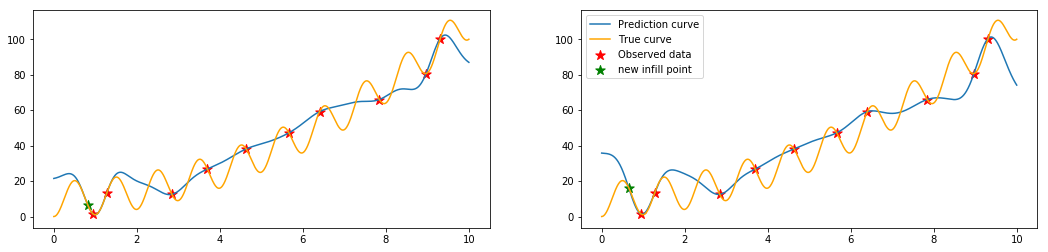

In [30]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 4))

# sub-plot for function 1
axs[0].plot(test_x[:, 0], model1.pred(torch.tensor(test_x).float()).numpy().reshape(-1), label="Prediction curve")
axs[0].plot(test_x[:, 0], f1_y, color="orange", label="True curve")



axs[0].scatter(
    model1.trainX[:10:, 0],
    model1.trainY[:10:, 0],
    marker="*",
    s=100,
    color="r",
    label="Observed data",
)


axs[0].scatter(
    EI_pointx_model1,
    EI_pointy_model1,
    marker="*",
    s=100,
    color="g",
    label="new infill point",
)



# sub-plot for function 2
axs[1].plot(test_x[:, 0], model2.pred(torch.tensor(test_x).float())[0].numpy().reshape(-1), label="Prediction curve")
axs[1].plot(test_x[:, 0], f1_y, color="orange", label="True curve")



axs[1].scatter(
    model2.trainX[:10, 0],
    model2.trainY[:10, 0],
    marker="*",
    s=100,
    color="r",
    label="Observed data",
)

axs[1].scatter(
    EI_pointx_model2,
    EI_pointy_model2,
    marker="*",
    s=100,
    color="g",
    label="new infill point",
)
axs[1].legend()

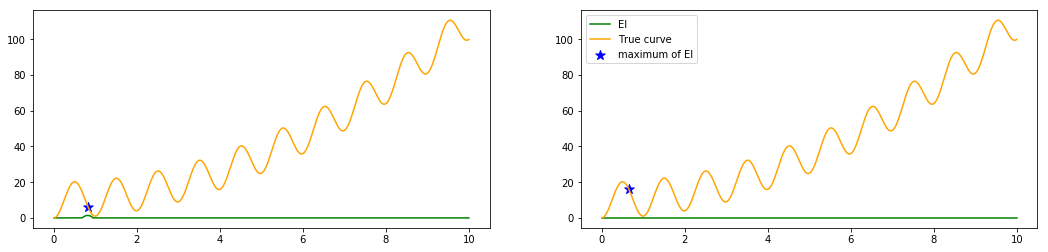

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 4))

# sub-plot for model1
axs[0].plot(test_x[:, 0], model1.EIvalue, color="green",label="EI")
axs[0].plot(test_x[:, 0], f1_y , color="orange", label="True curve")



axs[0].scatter(
    EI_pointx_model1,
    EI_pointy_model1,
    marker="*",
    s=100,
    color="b",
    label="maximum of EI",
)

# sub-plot for model2
axs[1].plot(test_x[:, 0], model2.EIvalue, color="green", label="EI")
axs[1].plot(test_x[:, 0], f1_y, color="orange", label="True curve")



axs[1].scatter(
    EI_pointx_model2,
    EI_pointy_model2,
    marker="*",
    s=100,
    color="b",
    label="maximum of EI",
)
axs[1].legend()



### for Testing function two

In [32]:
f2_y = Sphere_f(test_x)

In [33]:
model3.EIvalue = model3.EI(torch.tensor(test_x).float())

EI_pointx_model3 = model3.EI_get_points().numpy()
print(EI_pointx_model3)

EI_pointy_model3 =  Sphere_f_EI(EI_pointx_model3)
print(EI_pointy_model3)

[[0.]]
[0.]


In [34]:
model4.EIvalue = model4.EI(torch.tensor(test_x).float())

EI_pointx_model4 = model4.EI_get_points().numpy()
print(EI_pointx_model4)

EI_pointy_model4 =  Sphere_f_EI(EI_pointx_model4)
print(EI_pointy_model4)

[[0.]]
[0.]


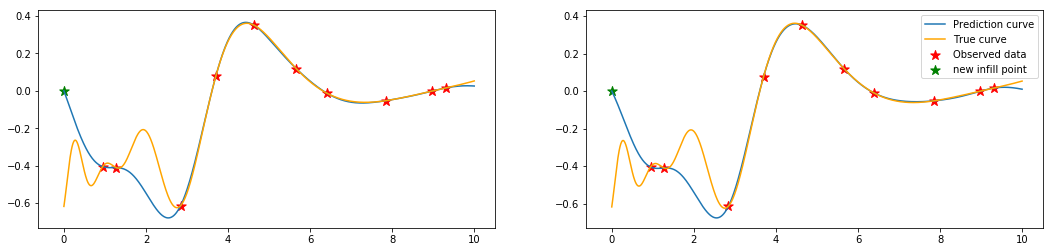

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 4))

# sub-plot for function 1
axs[0].plot(test_x[:, 0], model3.pred(torch.tensor(test_x).float()).numpy().reshape(-1), label="Prediction curve")
axs[0].plot(test_x[:, 0], f2_y, color="orange", label="True curve")



axs[0].scatter(
    model3.trainX[:10:, 0],
    model3.trainY[:10:, 0],
    marker="*",
    s=100,
    color="r",
    label="Observed data",
)


axs[0].scatter(
    EI_pointx_model3,
    EI_pointy_model3,
    marker="*",
    s=100,
    color="g",
    label="new infill point",
)



# sub-plot for function 2
axs[1].plot(test_x[:, 0], model4.pred(torch.tensor(test_x).float())[0].numpy().reshape(-1), label="Prediction curve")
axs[1].plot(test_x[:, 0], f2_y, color="orange", label="True curve")



axs[1].scatter(
    model4.trainX[:10, 0],
    model4.trainY[:10, 0],
    marker="*",
    s=100,
    color="r",
    label="Observed data",
)

axs[1].scatter(
    EI_pointx_model4,
    EI_pointy_model4,
    marker="*",
    s=100,
    color="g",
    label="new infill point",
)
axs[1].legend()

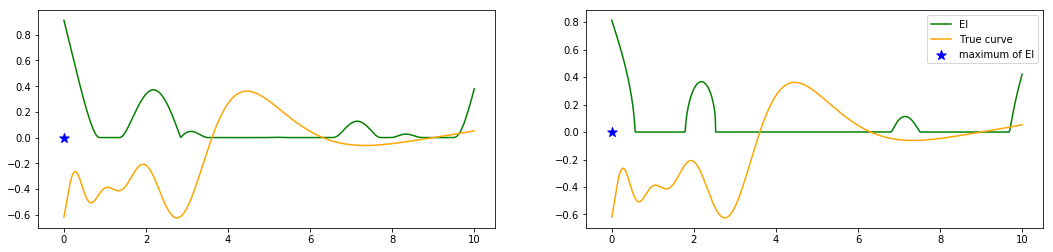

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 4))

# sub-plot for model1
axs[0].plot(test_x[:, 0], model3.EIvalue, color="green",label="EI")
axs[0].plot(test_x[:, 0], f2_y , color="orange", label="True curve")



axs[0].scatter(
    EI_pointx_model3,
    EI_pointy_model3,
    marker="*",
    s=100,
    color="b",
    label="maximum of EI",
)

# sub-plot for model2
axs[1].plot(test_x[:, 0], model4.EIvalue, color="green", label="EI")
axs[1].plot(test_x[:, 0], f2_y, color="orange", label="True curve")



axs[1].scatter(
    EI_pointx_model4,
    EI_pointy_model4,
    marker="*",
    s=100,
    color="b",
    label="maximum of EI",
)
axs[1].legend()

